### Initialize Database Connection and Load the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import poisson

from home_messages_db import HomeMessagesDB

db = HomeMessagesDB('sqlite:///myhome.db')

# Load the data
df_smartthings = db.get_smartthings()
df_weather = db.get_weather_data()

### Prepare the Data 

In [4]:
# Convert epoch time to datetime in df_smartthings and df_weather
df_smartthings['datetime'] = pd.to_datetime(df_smartthings['epoch'], unit='s')
df_weather['datetime'] = pd.to_datetime(df_weather['time'], unit='s')

# Extract weekends from the datetime
df_smartthings['is_weekend'] = df_smartthings['datetime'].dt.weekday >= 5
df_weather['is_weekend'] = df_weather['datetime'].dt.weekday >= 5

# Filter data to focus on motion detection events and only include 'active' events
motion_df = df_smartthings[(df_smartthings['capability'] == 'motionSensor') & (df_smartthings['value'] == 'active')]

# Merge the two datasets on the nearest datetime to align weather data with motion events
merged_df = pd.merge_asof(
    motion_df.sort_values('datetime'),
    df_weather.sort_values('datetime'),
    on='datetime',
    direction='nearest'
)

# Filter merged data to only include weekends
weekend_df = merged_df[merged_df['is_weekend_x']]

### Calculate Descriptives 

In [9]:
# Calculate descriptive statistics for key weather variables on weekends
weather_stats = weekend_df[['temperature_2m', 'relativehumidity_2m', 'rain']].describe()
print(weather_stats)

# Calculate the number of motion events per weekend day
weekend_df['date'] = weekend_df['datetime'].dt.date
motion_counts = weekend_df.groupby('date').size().reset_index(name='motion_count')

daily_weather = weekend_df.groupby('date')[['temperature_2m', 'rain']].mean().reset_index()

# Merge the motion counts back with the weather data for the corresponding dates
motion_weather_df = pd.merge(motion_counts, daily_weather, on='date')


       temperature_2m  relativehumidity_2m          rain
count    54068.000000         54068.000000  54068.000000
mean        10.172126            80.641378      0.123901
std          5.805972            11.495912      0.412653
min         -5.300000            34.000000      0.000000
25%          6.800000            74.000000      0.000000
50%          9.400000            83.000000      0.000000
75%         13.800000            90.000000      0.000000
max         31.100000           100.000000      7.000000


/var/folders/1t/r1rc54fd3s9_qs3h2wbr2xvh0000gn/T/ipykernel_76958/1999761680.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_df['date'] = weekend_df['datetime'].dt.date


### Perform Regression Analysis

In [10]:
# Perform Poisson regression analysis
poisson_model = poisson('motion_count ~ temperature_2m', data=motion_weather_df).fit()
print(poisson_model.summary())

Optimization terminated successfully.
         Current function value: 45.590501
         Iterations 4
                          Poisson Regression Results                          
Dep. Variable:           motion_count   No. Observations:                  157
Model:                        Poisson   Df Residuals:                      155
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Jun 2024   Pseudo R-squ.:                 0.03485
Time:                        15:36:59   Log-Likelihood:                -7157.7
converged:                       True   LL-Null:                       -7416.1
Covariance Type:            nonrobust   LLR p-value:                2.020e-114
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0168      0.009    695.037      0.000       6.000       6.034
temperature_2m  

### Make Scatterplot and Fit Regression Line 

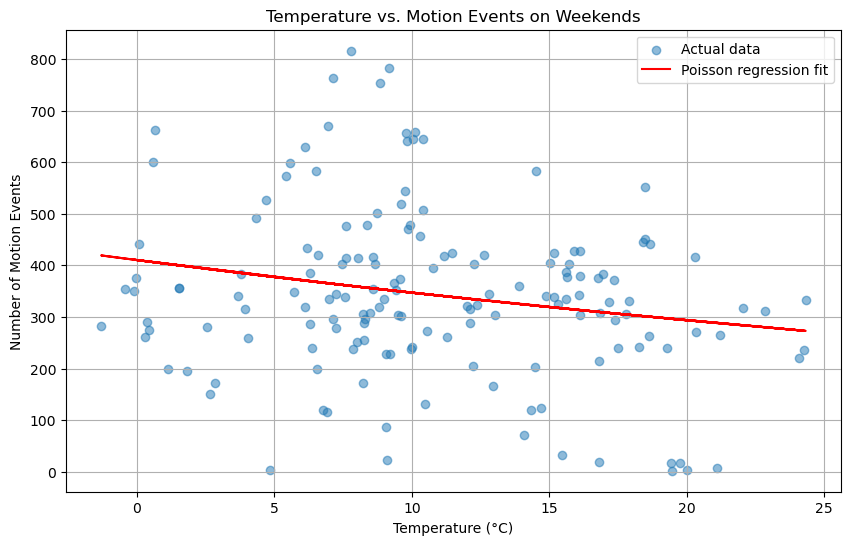

,date,motion_count,temperature_2m,rain,predicted_motion_count
0,2022-10-15,119,14.349580,0.054622,322.662715
1,2022-10-16,124,14.679839,0.014516,320.883943
2,2022-10-22,340,14.880588,0.000000,319.807504
3,2022-10-23,379,16.109763,0.074934,313.294837
4,2022-10-29,294,17.403401,0.347279,306.583803


In [11]:
# Predict and plot the results
motion_weather_df['predicted_motion_count'] = poisson_model.predict(motion_weather_df['temperature_2m'])

plt.figure(figsize=(10, 6))
plt.scatter(motion_weather_df['temperature_2m'], motion_weather_df['motion_count'], alpha=0.5, label='Actual data')
plt.plot(motion_weather_df['temperature_2m'], motion_weather_df['predicted_motion_count'], color='red', label='Poisson regression fit')
plt.title('Temperature vs. Motion Events on Weekends')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Motion Events')
plt.legend()
plt.grid(True)
plt.show()